In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0
Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)
println("")

In [4]:
t_max = 0.05
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [43]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, W_int_t = LvN_SI(
    W0,
    tspan,
    agg;
    reltol = 1e-10,
    abstol = 1e-10,
    alg = OrdinaryDiffEq.Tsit5(),
)

  0.120269 seconds (3.92 k allocations: 33.636 MiB)

([0.0, 0.00025, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225  …  0.04775, 0.048, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=27x27)
  basis: Basis(dim=27)
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …        0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …        0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.

In [51]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 2.4526719090891023e-11
3 8.13601318847338e-11
4 1.4979269457757496e-10
5 2.14511584929019e-10
6 2.649825404652762e-10
7 2.948496333276162e-10
8 3.01341479674446e-10
9 2.846934885122029e-10
10 2.4762681043222514e-10
11 1.9495999673707564e-10
12 1.337583200298443e-10
13 7.682678637696577e-11
14 6.132696423609118e-11
15 9.864166429749337e-11
16 1.3975924576761264e-10
17 1.6752694875897824e-10
18 1.7704123746535566e-10
19 1.6730159198125285e-10
20 1.4026029657154148e-10
21 1.009061472613144e-10
22 5.756748959780889e-11
23 2.2627908632032206e-11
24 1.1662256676149971e-11
25 1.0457499844652401e-11
26 9.074886639664586e-12
27 8.63366162349734e-12
28 9.28103342917783e-12
29 1.0866321000536494e-11
30 1.2778197776690052e-11
31 1.4066342382223199e-11
32 1.4062285503372514e-11
33 1.2902492979438595e-11
34 1.1771637022310297e-11
35 1.2001274479796711e-11
36 2.5554718856397418e-11
37 4.501440622685839e-11
38 5.947034474878012e-11
39 6.440370416062208e-11
40 5.864047335257498e-11
41 4.3393325

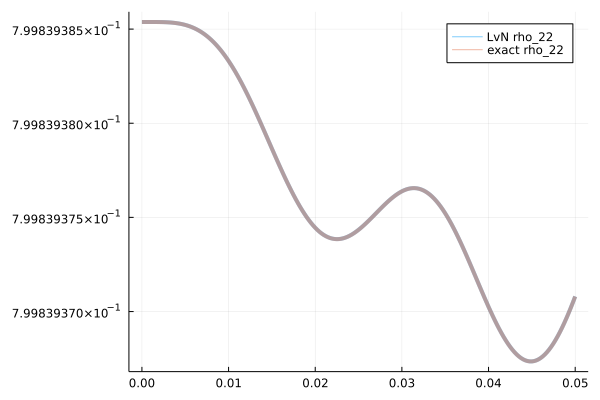

In [45]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    # rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t[t_i, :, :] = trace_bath(W_int_t[t_i].data, aggCore, aggTools)
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="LvN rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [56]:
using OpenQuantumSystems
include("test_liouville.jl")


Test Summary: | Pass  Total
liouville     |   22     22


Test.DefaultTestSet("liouville", Any[], 22, false, false)

In [8]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   11     11
Test Summary:       | Pass  Total
interaction picture |    9      9
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
